# Notebook for plotting nucleosome decentering data

This script was used to generate data in Nodelman et al., 2025 NSMB. It reads in a single csv file and plots data in a bar graph.

The expected format of the csv file is one construct per row, with the construct name first, followed by values from different replicates. Data can be separated by multiple commas, which allows experiments to be organized by the days they were carried out (OK to have empty cells/multiple commas without data between every one). Note that the first line is ignored (used for naming experimental datasets. Example data (used for paper) is Nodelman2025NSMB-DecenteringData-2025Jan31.csv

To run this on your computer, you must give the correct paths/directories for the data and output. These are labeled ###Edit this in the block 'Edit this block - define data filename and directories' 

This script was made to run with python 3.8.8 (conda install) and

jupyter core     : 4.7.1

jupyter-notebook : 6.3.0

qtconsole        : 5.0.3

ipython          : 7.22.0

ipykernel        : 5.3.4

jupyter client   : 6.1.12

jupyter lab      : 3.0.14

nbconvert        : 6.0.7


ipywidgets       : 7.6.3

nbformat         : 5.1.3

traitlets        : 5.0.5

## preamble

In [9]:
%matplotlib inline
from __future__ import division
import matplotlib
#import matplotlib as mpl

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import os
import sys
import time
import statistics
from pylab import *
import re
from scipy.interpolate import interp1d
from scipy.integrate import odeint
import scipy.optimize as opt
from scipy.optimize import curve_fit

matplotlib.rcParams['font.sans-serif']='Arial'
matplotlib.rcParams.update({'font.size': 24, "axes.formatter.limits": (-4,4)})
plotStyles={"markersize":12,"markeredgewidth":3.0,"linewidth":3.0}


colorlist=["red","orange","green","dodgerblue","darkviolet","gray","brown","orange","chocolate","blue",
          "pink","navajowhite","lightgray","cyan","lightskyblue","mediumpurple","red","olive","brown","green",
           "dodgerblue","darkviolet","red","orange","green","yellowgreen","darkviolet","gray","brown","orange","chocolate","blue",
          "pink","navajowhite","lightgray","cyan","lightskyblue","mediumpurple","red","olive","brown","green",
           "dodgerblue","darkviolet","red","orange","green","dodgerblue","darkviolet","gray","brown","orange","chocolate","blue",
          "pink","navajowhite","lightgray","cyan","lightskyblue","mediumpurple","red","olive","brown","green",
           "dodgerblue","darkviolet","red","orange","green","dodgerblue","darkviolet","gray","brown","orange","chocolate","blue",
          "pink","navajowhite","lightgray","cyan","lightskyblue","mediumpurple","red","olive","brown","green",
           "dodgerblue","darkviolet"
          ]

## defs

In [10]:
def flatten(l):
    ''' 
    flatten a list of lists, from stack exchange
    https://stackoverflow.com/questions/952914/how-do-i-make-a-flat-list-out-of-a-list-of-lists
    '''
    return [item for sublist in l for item in sublist]

def gettimestamp():
    '''
    returns a string of the current day-hour-min
    be sure to import time in preamble
    '''
    if time.localtime().tm_min < 10:
        currenttimestamp=str(time.localtime().tm_year)+"_"+str(time.localtime().tm_mon)+"_"+str(time.localtime().tm_mday)+"-"+str(time.localtime().tm_hour)+"0"+str(time.localtime().tm_min)
    else:
        currenttimestamp=str(time.localtime().tm_year)+"_"+str(time.localtime().tm_mon)+"_"+str(time.localtime().tm_mday)+"-"+str(time.localtime().tm_hour)+str(time.localtime().tm_min)
    return(currenttimestamp)


def writelisttofile(tempfilename,templist):
    outputfile=open(tempfilename,"w")
    for line in templist:
        outputfile.write(line)
    outputfile.close()

def extractdatacolumn(tempfilename, datacolumn):
    '''read a file and output a list, here assuming all are floats
    datacolumn input indicates what column to extract
    '''
    tempfile=open(tempfilename,"r")
    datalist=[]
    tempfilelist=tempfile.readlines()
    for line in tempfilelist:
        temp=line.split()
        datalist.append(float(temp[datacolumn]))
    return datalist

def extractdatacolumncsv(tempfilename, datacolumn):
    '''read a file and output a list, here assuming all are floats
    datacolumn input indicates what column to extract
    '''
    #print("###### extractdatacolumncsv ######")
    tempfile=open(tempfilename,"r")
    datalist=[]
    tempfilelist=tempfile.readlines()
    for line in tempfilelist:
        #print(line,"line")
        line.strip()
        if "," in line:
            temp=line.split(",")
            #print(temp)
            for i in range(len(temp)):
                if '\ufeff' in temp[i]:
                    temp[i]=temp[i][1:]
            datalist.append(float(temp[datacolumn]))
    return datalist
    
def convertcsvtodict(tempfilename,existingdict):
    '''
    this function takes a filename, assuming it to be a csv file, and dumps data into existing dictionary
    note that first line of csv file is skipped.
    data format is for first item of each line to be construct name, followed by data.
    some data may be blank
    '''
    tempfile=open(tempfilename,"r")
    datalist=[]
    tempfilelist=tempfile.readlines()
    tempfile.close()
    existingdict["constructlist-all"]=[]
    for i in range(1,len(tempfilelist)): ### skips first line
        linelisttemp=tempfilelist[i].split(",")
        #print(linelisttemp)
        #print("constructname = ",linelisttemp[0])
        ### make new dictionary entry based on this line of data; first item is key==construct name
        existingdict[linelisttemp[0]]={}
        existingdict[linelisttemp[0]]["constructname"]=linelisttemp[0]
        existingdict[linelisttemp[0]]["colordefault"]=colorlist[i]
        existingdict[linelisttemp[0]]["position"]=i
        existingdict[linelisttemp[0]]["origdata"]=[]
        existingdict["constructlist-all"].append(linelisttemp[0])
        for j in range(1,len(linelisttemp)):
            if linelisttemp[j]=="" or linelisttemp[j]=="\n":
                continue
                #print("EMPTY")
            else:
                existingdict[linelisttemp[0]]["origdata"].append(float(linelisttemp[j]))
                #print(linelisttemp[j])    
    return(existingdict)

def datarawstrip(alldatalist, keystart="$DATA", keyend="$ENDDATA", keystartdelay=4):
    '''
    this function strips out all lines that are between key1 and key 2.
    This is helpful for data collected on the Aviv fluorimeter in the biophysics center.
    '''
    newlist=[]
    counter=0
    for line in alldatalist:
        if keystart in line:
            counter=1
            continue
        if keyend in line:
            break
        if counter>0:
            counter+=1
            if counter>keystartdelay:
                newlist.append(line)
    return(newlist)

def makecleancsv(inputfilename):
    '''this will remove weird <U+FEFF> at the start of file, seems to be from excel?
    and output a new csv without this issue'''
    tempfileraw=open(inputfilename,"r")
    tempfile=tempfileraw.readlines()
    for line in tempfile:
        if "\xef\xbb\xbf" in line:
            print(line,YES)
        else:
            print("\tNO - ",line)

def convert1Dlisttoarray(inputlist):
    '''
    this function takes a list as input and returns a numpy array of same length
    this will probably fail if not a list of numbers
    '''
    nplistarray=np.zeros((len(inputlist),))
    for i in range(0,len(inputlist)):
        nplistarray[i]=inputlist[i]
    return(nplistarray)


# Edit this block - define datafile name and directories

In [13]:
### GDB-remove
csvdirectory="/Users/gbowman3/OneDrive - Johns Hopkins/BowmanLabOneDrive/IlanaGregShared/2022-BridgeStudy/Decentering-IMN/csv/"
### Edit this ### 
#csvdirectory="/path/to/data/"

csvdatafile = csvdirectory+"Nodelman2025NSMB-DecenteringData-2025Jan31.csv"

###GDB-remove
outputdirectory="/Users/gbowman3/temp/"
### Edit this ###
#outputdirectory="/Folder/to/put/output/pdfs/"

### create output directory if it doesn't already exist
try:
    os.listdir(outputdirectory)
except FileNotFoundError:
    os.mkdir(outputdirectory)
    print("created new directory for output files:\n{}\n\n".format(outputdirectory))
print(outputdirectory)


/Users/gbowman3/temp/


In [15]:
### calculate mean and standard deviation for each construct
decenteringdict ={}

### read data from file
decenteringdict=convertcsvtodict(csvdatafile,decenteringdict)

### calculate avg and stdev, given the raw data just input
for construct in decenteringdict["constructlist-all"]:
    decenteringdict[construct]["AVG"]=np.mean(decenteringdict[construct]["origdata"])
    decenteringdict[construct]["STD"]=np.std(decenteringdict[construct]["origdata"])



for item in decenteringdict["constructlist-all"]:
    print(item)
    print("{} {} {:5.2f}+/-{:5.2f}".format(item, decenteringdict[item]["colordefault"],decenteringdict[item]["AVG"],decenteringdict[item]["STD"]))


nuc alone
nuc alone orange  0.01+/- 0.01
wt
wt green  0.10+/- 0.02
120B-SAIL-Lobe2
120B-SAIL-Lobe2 dodgerblue  0.22+/- 0.01
120B-Lobe2
120B-Lobe2 darkviolet  0.26+/- 0.02
120B-SAIL
120B-SAIL gray  0.02+/- 0.01
120B-876-881
120B-876-881 brown  0.11+/- 0.01
120B-884-889
120B-884-889 orange  0.31+/- 0.02
120B-890-895
120B-890-895 chocolate  0.24+/- 0.01
120B-896-901
120B-896-901 blue  0.28+/- 0.01
120B-902-907
120B-902-907 pink  0.20+/- 0.02
L886N-L889N-L891N
L886N-L889N-L891N navajowhite  0.29+/- 0.02
L886G-L889G-L891G
L886G-L889G-L891G lightgray  0.28+/- 0.01
L699Q
L699Q cyan  0.30+/- 0.02
901-902insertGGS
901-902insertGGS lightskyblue  0.20+/- 0.01
F917N-L918N-F921N
F917N-L918N-F921N mediumpurple  0.16+/- 0.00
I843N
I843N red  0.01+/- 0.01
KAK
KAK olive  0.15+/- 0.02
M652Q-KAK
M652Q-KAK brown  0.22+/- 0.02
M652Q
M652Q green  0.13+/- 0.01


In [16]:
### set colors for bar graph

decenteringdict['nuc alone']['color']="white"
decenteringdict['wt']['color']="dimgray"
decenteringdict['120B-SAIL']['color']="lawngreen"
decenteringdict['120B-Lobe2']['color']="red"
decenteringdict['120B-SAIL-Lobe2']['color']="red"
decenteringdict['120B-876-881']['color']="forestgreen"
decenteringdict['120B-884-889']['color']="red"
decenteringdict['120B-890-895']['color']="darkorange"
decenteringdict['120B-896-901']['color']="gold" #"lightskyblue"
decenteringdict['120B-902-907']['color']="khaki"
decenteringdict['901-902insertGGS']['color']="khaki"
decenteringdict['L886G-L889G-L891G']['color']="red"
decenteringdict['L886N-L889N-L891N']['color']="red"
decenteringdict['F917N-L918N-F921N']['color']="dodgerblue" #"purple"
decenteringdict['L699Q']['color']="green"
decenteringdict['M652Q']['color']="white"
decenteringdict['I843N']['color']="magenta"  
decenteringdict['KAK']['color']="paleturquoise"  
decenteringdict['M652Q-KAK']['color']="paleturquoise"  

In [17]:
for construct in decenteringdict["constructlist-all"]:
    decenteringdict[construct]['linecolor']="black"
    decenteringdict[construct]["linewidth"]=1
    decenteringdict[construct]["linestyle"]='solid'
    if "SAIL-Lobe2" in construct:
        decenteringdict[construct]['linecolor']="lawngreen"
        decenteringdict[construct]["linewidth"]=5
    elif "120B-Lobe2" in construct:
        decenteringdict[construct]['linecolor']="orange"
        decenteringdict[construct]["linewidth"]=5
    elif "L886" in construct:
        decenteringdict[construct]["linestyle"]='dashed'
        decenteringdict[construct]['linecolor']="black"
        decenteringdict[construct]["linewidth"]=2
    elif "nuc" in construct:
        decenteringdict[construct]['linecolor']="black"
        decenteringdict[construct]["linewidth"]=1
    elif "insert" in construct:
        decenteringdict[construct]["linestyle"]='dotted'
        decenteringdict[construct]['linecolor']="black"
        decenteringdict[construct]["linewidth"]=2
    elif "M652Q-KAK" in construct:
        decenteringdict[construct]["linestyle"]='dotted'
        decenteringdict[construct]['linecolor']="black"
        decenteringdict[construct]["linewidth"]=2
    elif "M652Q" in construct:
        decenteringdict[construct]["linestyle"]='dotted'
        decenteringdict[construct]['linecolor']="black"
        decenteringdict[construct]["linewidth"]=2
        

In [18]:

### reset order: For Figure 1

decenteringdict["constructlist"]=['nuc alone', 
                                  'wt', 
                                  '120B-SAIL', 
                                  '120B-876-881', 
                                  #'120B-SAIL-Lobe2', 
                                  #'120B-Lobe2',
                                  '120B-884-889', 
                                  '120B-890-895', 
                                  '120B-896-901', 
                                  '120B-902-907', 
                                  'L886N-L889N-L891N',
                                  'L886G-L889G-L891G', 
                                  #'901-902insertGGS',
                                  
                                  'F917N-L918N-F921N'
                                  
                                  #'M652Q',
                                  #'KAK',
                                  #'M652Q-KAK'
                                  #'I843N',
                                  #'L699Q'
                                  
                                 ]

### change position:
### here set position automatically from the list
for i in range(len(decenteringdict["constructlist"])):
    decenteringdict[decenteringdict["constructlist"][i]]['position']=i

for item in decenteringdict["constructlist"]:
    print("*{}*".format(item))



*nuc alone*
*wt*
*120B-SAIL*
*120B-876-881*
*120B-884-889*
*120B-890-895*
*120B-896-901*
*120B-902-907*
*L886N-L889N-L891N*
*L886G-L889G-L891G*
*F917N-L918N-F921N*


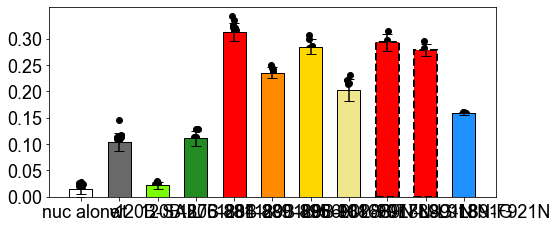

In [19]:
### plot bar graphs, based on construct list in dictionary
plotStyles3={"markersize":9,"markeredgewidth":2.0,"linewidth":6.0}
mpl.rcParams.update({'font.size': 18, "axes.formatter.limits": (-4,4)})
mpl.rcParams.update({"figure.figsize": (8,3.5),'errorbar.capsize': 2})


updatedpositions = []
for construct in decenteringdict["constructlist"]:
    updatedpositions.append(decenteringdict[construct]["position"])
    
fig, ax = plt.subplots()
spread=0.2
w = 0.6    # bar width
cap=5
for construct in decenteringdict["constructlist"]:
    ax.bar(
           decenteringdict[construct]["position"],
           height = decenteringdict[construct]["AVG"],
           yerr=decenteringdict[construct]["STD"],
           capsize=cap,
           width=w,
           linestyle = decenteringdict[construct]["linestyle"],
           linewidth = decenteringdict[construct]["linewidth"],
           color=decenteringdict[construct]["color"],
           edgecolor = decenteringdict[construct]["linecolor"]
            #color = (0,0,0,0)#"black"
          )
for construct in decenteringdict["constructlist"]:
    for point in decenteringdict[construct]["origdata"]:
        ax.scatter(
            decenteringdict[construct]["position"] + np.random.random()*w*spread-w*spread/2,point,color="black")


plt.xticks(updatedpositions,labels=decenteringdict["constructlist"])
plt.yticks(np.arange(0, 0.31, 0.05))
#add time stamp to filename
workingname=outputdirectory+"Plot-DecenteringData-"+gettimestamp()+".pdf"

#uncomment to save plot as a PDF
savefig(workingname,format='pdf',dpi=300, bbox_inches='tight')
#ax.set_xticks(updatedpositions,decenteringdict["constructlist"])
plt.show()

In [20]:

### reset order: ExtDataFig2
decenteringdict["constructlist"]=['nuc alone', 
                                  'wt', 
                                  #'120B-SAIL', 
                                  #'120B-876-881', 
                                  '120B-SAIL-Lobe2', 
                                  '120B-Lobe2',
                                  #'120B-884-889', 
                                  #'120B-890-895', 
                                  #'120B-896-901', 
                                  #'120B-902-907', 
                                  #'L886N-L889N-L891N',
                                  #'L886G-L889G-L891G', 
                                  '901-902insertGGS'
                                  
                                  #'F917N-L918N-F921N'
                                  
                                  #'M652Q',
                                  #'KAK',
                                  #'M652Q-KAK'
                                  #'I843N',
                                  #'L699Q'
                                  
                                 ]

### change position:
### here set position automatically from the list
for i in range(len(decenteringdict["constructlist"])):
    decenteringdict[decenteringdict["constructlist"][i]]['position']=i

for item in decenteringdict["constructlist"]:
    print("*{}*".format(item))
print(decenteringdict["constructlist"])


*nuc alone*
*wt*
*120B-SAIL-Lobe2*
*120B-Lobe2*
*901-902insertGGS*
['nuc alone', 'wt', '120B-SAIL-Lobe2', '120B-Lobe2', '901-902insertGGS']


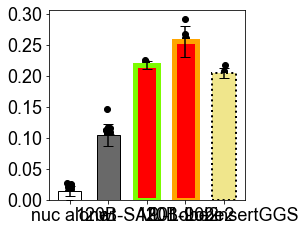

In [21]:
### plot bar graphs, based on construct list in dictionary
plotStyles3={"markersize":9,"markeredgewidth":2.0,"linewidth":6.0}
mpl.rcParams.update({'font.size': 18, "axes.formatter.limits": (-4,4)})
mpl.rcParams.update({"figure.figsize": (3.5,3.5),'errorbar.capsize': 2})


updatedpositions = []
for construct in decenteringdict["constructlist"]:
    updatedpositions.append(decenteringdict[construct]["position"])
    
fig, ax = plt.subplots()
spread=0.2
w = 0.6    # bar width
cap=5
for construct in decenteringdict["constructlist"]:
    ax.bar(
           decenteringdict[construct]["position"],
           height = decenteringdict[construct]["AVG"],
           yerr=decenteringdict[construct]["STD"],
           capsize=cap,
           width=w,
           linestyle = decenteringdict[construct]["linestyle"],
           linewidth = decenteringdict[construct]["linewidth"],
           color=decenteringdict[construct]["color"],
           edgecolor = decenteringdict[construct]["linecolor"]
            #color = (0,0,0,0)#"black"
          )
for construct in decenteringdict["constructlist"]:
    for point in decenteringdict[construct]["origdata"]:
        ax.scatter(
            decenteringdict[construct]["position"] + np.random.random()*w*spread-w*spread/2,point,color="black")


plt.xticks(updatedpositions,labels=decenteringdict["constructlist"])
plt.yticks(np.arange(0, 0.31, 0.05))
#add time stamp to filename
workingname=outputdirectory+"Plot-DecenteringData-supplFig-"+gettimestamp()+".pdf"

#uncomment to save plot as a PDF
savefig(workingname,format='pdf',dpi=300, bbox_inches='tight')
#ax.set_xticks(updatedpositions,decenteringdict["constructlist"])
plt.show()

In [22]:

### reset order: ExtDataFig4
decenteringdict["constructlist"]=['nuc alone', 
                                  'wt', 
                                  
                                  '120B-884-889', 
                                  
                                  'KAK',
                                  'M652Q-KAK',
                                  'M652Q'
                                  
                                  
                                  #'M652Q'
                                  #'I843N',
                                  #'L699Q'
                                  
                                 ]

### change position:
### here set position automatically from the list
for i in range(len(decenteringdict["constructlist"])):
    decenteringdict[decenteringdict["constructlist"][i]]['position']=i

for item in decenteringdict["constructlist"]:
    print("*{}*".format(item))
print(decenteringdict["constructlist"])


*nuc alone*
*wt*
*120B-884-889*
*KAK*
*M652Q-KAK*
*M652Q*
['nuc alone', 'wt', '120B-884-889', 'KAK', 'M652Q-KAK', 'M652Q']


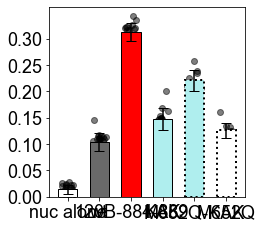

In [23]:
### plot bar graphs, based on construct list in dictionary
plotStyles3={"markersize":9,"markeredgewidth":2.0,"linewidth":6.0}
mpl.rcParams.update({'font.size': 18, "axes.formatter.limits": (-4,4)})
mpl.rcParams.update({"figure.figsize": (3.5,3.5),'errorbar.capsize': 2})


updatedpositions = []
for construct in decenteringdict["constructlist"]:
    updatedpositions.append(decenteringdict[construct]["position"])
    
fig, ax = plt.subplots()
spread=0.75
w = 0.6    # bar width
cap=5
for construct in decenteringdict["constructlist"]:
    ax.bar(
           decenteringdict[construct]["position"],
           height = decenteringdict[construct]["AVG"],
           yerr=decenteringdict[construct]["STD"],
           capsize=cap,
           width=w,
           linestyle = decenteringdict[construct]["linestyle"],
           linewidth = decenteringdict[construct]["linewidth"],
           color=decenteringdict[construct]["color"],
           edgecolor = decenteringdict[construct]["linecolor"]
            #color = (0,0,0,0)#"black"
          )
for construct in decenteringdict["constructlist"]:
    for point in decenteringdict[construct]["origdata"]:
        ax.scatter(
            decenteringdict[construct]["position"] + np.random.random()*w*spread-w*spread/2,point,color="black", alpha=0.5)


plt.xticks(updatedpositions,labels=decenteringdict["constructlist"])
plt.yticks(np.arange(0, 0.31, 0.05))
#add time stamp to filename
workingname=outputdirectory+"Plot-DecenteringData-supplfig-M652Q-"+gettimestamp()+".pdf"

#uncomment to save plot as a PDF
savefig(workingname,format='pdf',dpi=300, bbox_inches='tight')
#ax.set_xticks(updatedpositions,decenteringdict["constructlist"])
plt.show()